In [1]:
import dill
import pandas as pd
import numpy as np
import calour as ca
from bisect import bisect_right
from itertools import combinations

from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
pd.set_option('max_colwidth', 200)
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

# import relative abundance ASV table and events windows

In [4]:
with open('../data/ASV-table-and-eat-windows-for-MA.pkl', 'rb') as f:
    saliva_ma, ma_eat_windows = dill.load(f)

**saliva_ma**: calour.AmpliconExperiment  
relative abundance table of MA samples.  
**ma_eat_windows**: tuple of tuples
((eat_start_timepoint1, eat_end_timepoint1), (eat_start_timepoint2, eat_end_timepoint2)...)  
each tuple is an eating window.  

In [5]:
# sample and feature counts of each subject
saliva_ma

AmpliconExperiment with 207 samples, 531 features

In [6]:
# display sample metadata
saliva_ma.sample_metadata.head(2)

,BarcodeSequence,Primer_Plate,Well_ID,Plating,Extraction_robot,TM1000_8_tool,Processing_robot,TM300_8_tool,TM50_8_tool,Orig_name,Description,drink,Host_ID,Barcode,eat,other,sleep,events,body site,Day,Hour,Min,dayhourmin,DATETIME,_sample_id,_calour_original_abundance,observed_otus,shannon,faith_pd
#SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19122,ATCGTAGTGGTC,2,F6,GG,NEWE,311172B,ROBE,311313B,111075B,19122,Amnon_Med_2_19122_F6,NaN,MA,19122,NaN,NaN,yes,sleep,saliva,1,7,0,1:07:00,2014-09-15 07:00:00,19122,13584.0,75,3.633408,6.924340
19123,GCTGCCCACCTA,2,C5,GG,NEWE,311172B,ROBE,311313B,111075B,19123,Amnon_Med_2_19123_C5,NaN,MA,19123,NaN,NaN,NaN,NaN,saliva,1,7,30,1:07:30,2014-09-15 07:30:00,19123,5040.0,71,3.998352,7.172192


In [7]:
# display feature metadata
saliva_ma.feature_metadata.head(2)

,_feature_id,taxonomy,taxa,kingdom,phylum,class,order,family,genus,species
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGTAAATTAAGTCAGGTGTGAAAGTTCGGGGCTCAACCCCGTGATTGCACCTGATACTGATAAACTAGAGTGTTGGAGAGGTAAGTGGAATTCCTAG,AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGTAAATTAAGTCAGGTGTGAAAGTTCGGGGCTCAACCCCGTGATTGCACCTGATACTGATAAACTAGAGTGTTGGAGAGGTAAGTGGAATTCCTAG,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Peptococcus;s__sp._HMT_167,s__sp._HMT_167,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Peptococcaceae,g__Peptococcus,s__sp._HMT_167
AGCGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGTGACTTAAGTGAGGTGTGAAAGCCCCGGGCTTAACCTGGGAATTGCATTTCATACTGGGTCGCTAGAGTACTTTAGGGAGGGGTAGAATTCCACG,AGCGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGTGACTTAAGTGAGGTGTGAAAGCCCCGGGCTTAACCTGGGAATTGCATTTCATACTGGGTCGCTAGAGTACTTTAGGGAGGGGTAGAATTCCACG,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus;s__parainfluenzae,s__parainfluenzae,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pasteurellales,f__Pasteurellaceae,g__Haemophilus,s__parainfluenzae


# filter ASVs
Before eat-responding bacteria analysis, we removed ASVs with low prevalence and low unique counts. 

## filter ASVs with low prevalence

In [8]:
prev = 0.1
cutoff = 0.0001

In [9]:
# keep features present in more than 10% of MA samples
saliva_ma_f = saliva_ma.filter_prevalence(prev, cutoff=cutoff) 
saliva_ma, saliva_ma_f

(AmpliconExperiment with 207 samples, 531 features,
 AmpliconExperiment with 207 samples, 176 features)

## filter ASVs with low unique counts

In [10]:
n = 5 

In [11]:
# count unique_counts for each ASV, and compare it with cutoff, return a boolen list 
b = [len(set(saliva_ma_f[:, i])) > n + 1 for i in saliva_ma_f.feature_metadata.index]
# filter ASVs by the boolean list
asvs = saliva_ma_f.feature_metadata.index[b]
# keep filtered ASVs
saliva_ma_f.filter_ids(asvs, axis='f', inplace=True)

AmpliconExperiment with 207 samples, 133 features

# ensure that samples are sorted in time order

samples are already sorted in time order

In [12]:
saliva_ma.sample_metadata['DATETIME'].is_monotonic_increasing

True

# identify eat-responding bacteria based on a z-score method
We developed a z-score method to measure how much the abundance change induced by eating deviates from normal fluctuations for a given ASV.

Here we calulated the z-score value of one ASV in MA as a demo.

In [13]:
asv = 'TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGAGTGCGCAGGCGGTTTTGCAAGACCGATGTGAAATCCCCGGGCTTAACCTGGGAACTGCATTGGTGACTGCAAGGCTAGAGTGTGTCAGAGGGAGGTGGAATTCCGCA'

## calculate the distribution of normal fluctuations 
For each ASV in each subject, we computed a vector (D) consisting of the abundance differences between every 2 samples that were collected within 1 hr. The vector D represents the distribution of normal fluctuations in abundance for this ASV.

In [14]:
tps = saliva_ma.sample_metadata['DATETIME'].tolist() # sampling datetime
abund = saliva_ma[:, asv] # relative abundance

In [15]:
window = '1H' 

In [16]:
def monotonic(lst):
    '''test if the list is monotonic'''
    diff = np.diff(lst)
    return np.all(diff <= 0) or np.all(diff >= 0)

In [17]:
def calc_abund_diff(abund_lst, tps_lst):
    '''calculate the monotonic abundance difference.
    abund_list : list
    tps_list : list
        abund_list and tps_list should be paired
    
    returns
    -------
    max_value, t_start, t_end
    max_value is the monotonic abundance difference within this time window.
    t_start and t_end are timestamps.
    max_value = the relative abundance at t_end - the relative abundance at t_start
    '''
    from itertools import combinations
    v_abs_max = 0
    v_a = 0
    v_b = 0
    # calculate the diff between every two data
    for a, b in combinations(range(len(abund_lst)), 2): 
        if monotonic(abund_lst[a:b]): # make sure the list is monotonic
            v = abund_lst[b] - abund_lst[a] # b is always greater than a
            v_abs_max = max([v_abs_max, v], key=abs) # update the max value
            if v_abs_max == v: # update the index to get tps
                v_a = a
                v_b = b
    return v_abs_max, tps_lst[v_a], tps_lst[v_b]

In [18]:
# calculate the distribution of normal fluctuations
v_ta_tb = [] 
for i in range(len(abund)):
    # iterate from the first time point, slice time series to 1 hr window
    tps_i = tps[i]
    tps_end = tps[i] + pd.to_timedelta(window)
    tps_end_index = bisect_right(tps, tps_end)
    tps_within_window = tps[i:tps_end_index]
    abund_within_window = abund[i:tps_end_index]
    # calculate the monotomic abundance difference within the window
    v_abs_max = 0
    v_a = 0
    v_b = 0
    if len(abund_within_window) > 1:
        v_abs_max, t_a, t_b = calc_abund_diff(abund_within_window, 
                                              tps_within_window)
        v_ta_tb.append([v_abs_max, t_a, t_b]) 

In [19]:
v_ta_tb[0]

[0.03916960438699569,
 Timestamp('2014-09-15 07:00:00'),
 Timestamp('2014-09-15 07:30:00')]

In [20]:
# get vector D (distribution of normal fluctuations)
D = [v_ta_tb[i][0] for i in range(len(v_ta_tb))]

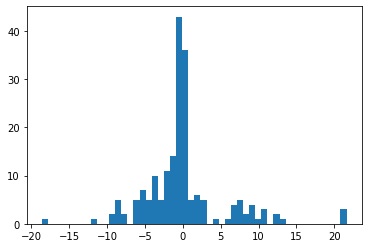

In [21]:
plt.hist(D, bins=50);

## abundance difference induced by eating

Next, we calculated the abundance change induced by eating.  

In [22]:
v_abs_max_eat = []
for t1, t2 in ma_eat_windows:
    v = []
    for v_abs_max, t_a, t_b in v_ta_tb:
        # check if [t_a, t_b] in eat window [t1, t2]
        if (t_a >= t1) and (t_b <=t2 + pd.to_timedelta(window)):
            # if v_abs_max is negative value, and t_a is after t2, 
            # basically the ASV increased due to eating first, and decreased more after that. 
            # in this situation, we are more interested in how much it increased.
            # so we delete the negative value even if t_a and t_b both locate within eat window.
            if not ((v_abs_max < 0) and (t_a >= t2)):
                v.append(v_abs_max)
    
    if len(v) > 0:
        v_abs_max_eat.append(max(v, key=abs)) # the absolute max value within this window was taken as the abundance difference induced by eating

## calculate zscore

The z-score was computed as 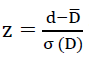 for each eating time window, where d is the abundance change induced by eating, D̅ is the mean of D, σ (D) is the standard deviation of D.

In [23]:
def calc_zscore(observed_value, null_values):
    '''calculate z-score'''
    from scipy.stats import norm
    null_mean = np.mean(null_values)
    null_std = np.std(null_values)
    z_score = (observed_value - null_mean) / null_std
    return z_score

In [24]:
asv_zscores = [calc_zscore(d, D) for d in v_abs_max_eat]
asv_zscores

[0.29955509213708276,
 0.44852896337395154,
 1.2976800294241035,
 1.7148068688873364,
 1.9159215950571091,
 1.7148068688873364,
 2.5490605478138018,
 1.3125774165477904,
 1.6626660139544323,
 1.707358175325493,
 1.387064352166225,
 1.4392052070991288,
 0.19527338227127455,
 1.4987947555938763,
 4.105837502239081,
 2.3107023538348117,
 1.997857224237387]

The mean of the z-scores of all the eating windows was the final measure on how much this ASV responded to eating.

In [25]:
np.mean(asv_zscores)

1.6210409616970718

# temporal order of eat-increasing bacteria

we intergated all the eat windows in subject MA together to reveal the temperoral response of the eat-increasing bacteria.

## eat-increasing ASVs

Top 8 ASVs that exist in at least two individuals with highest average z-score were used to visualize the temperoal order.

In [26]:
# 4 of the ASVs were enriched in tongue samples
asvs_tongue = ['TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGGACGCGTAGGCGGATTATCAAGTCTCTTGTGAAATCCTATGGCTTAACCATAGAACTGCTTGGGAAACTGATAATCTAGAGTGAGGGAGAGGCAGATGGAATTGGTGG',
 'TACGTATGTCGCGAGCGTTATCCGGAATTATTGGGCATAAAGGGCATCTAGGCGGATATACAAGTCAGGGGTGAAAACTTAGGGCTCAACTCAAAGCTTGCCTTTGAAACTGTATATCTAGAGTGCTGGAGAGGTGGACGGAACTACACG',
 'TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAATGGCAAGTCTGAAGTGAAATACCCGGGCTCAACCTGGGAACTGCTTTGGAAACTGTTGTTCTAGAGTGTTGGAGAGGTAAGTGGAATTCCTGG',
 'TACGTAGGGCGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCTTGTAGGCGGTTGGTCGCGTCTGCCGTGAAATTCTCTGGCTTAACTGGGGGCGTGCGGTGGGTACGGGCTGACTTGAGTGCGGTAGGGGAGACTGGAACTCCTGG']

In [27]:
# the other 4 ASVs were enriched in dental plaque samples
asvs_plaque = ['TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGAGTGCGCAGGCGGTTTTGCAAGACCGATGTGAAATCCCCGGGCTTAACCTGGGAACTGCATTGGTGACTGCAAGGCTAGAGTGTGTCAGAGGGAGGTGGAATTCCGCA',
 'TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGGGCGCAGACGGTTACTTAAGCAGGATGTGAAATCCCCGGGCTCAACCTGGGAATTGCGTTCTGAACTGGGTGGCTAGAGTGTGTCAGAGGGGGGTAGAATTCCACG',
 'TACGTAGGGCGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTTGTAGGCGGTTGGTCGCGTCTGCTGTGAAAGGCCGGGGCTTAACTCCGGTTTTGCAGTGGGTACGGGCTAACTAGAGTGCAGTAGGGGAGACTGGAATTCCTGG',
 'TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGAGTGCGCAGGCGGTTTTGCAAGACCGATGTGAAATCCCCGGGCTTAACCTGGGAACTGCATTGGTGACTGCAAGGCTAGAGTGTGTCAGAGGGAGGTGGAACTCCGCA']

In [28]:
table = saliva_ma.filter_ids(asvs_plaque + asvs_tongue, axis='f').to_pandas(sample_field='DATETIME')
table.head(2)

,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGAGTGCGCAGGCGGTTTTGCAAGACCGATGTGAAATCCCCGGGCTTAACCTGGGAACTGCATTGGTGACTGCAAGGCTAGAGTGTGTCAGAGGGAGGTGGAATTCCGCA,TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGGGCGCAGACGGTTACTTAAGCAGGATGTGAAATCCCCGGGCTCAACCTGGGAATTGCGTTCTGAACTGGGTGGCTAGAGTGTGTCAGAGGGGGGTAGAATTCCACG,TACGTAGGGCGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTTGTAGGCGGTTGGTCGCGTCTGCTGTGAAAGGCCGGGGCTTAACTCCGGTTTTGCAGTGGGTACGGGCTAACTAGAGTGCAGTAGGGGAGACTGGAATTCCTGG,TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGAGTGCGCAGGCGGTTTTGCAAGACCGATGTGAAATCCCCGGGCTTAACCTGGGAACTGCATTGGTGACTGCAAGGCTAGAGTGTGTCAGAGGGAGGTGGAACTCCGCA,TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGGACGCGTAGGCGGATTATCAAGTCTCTTGTGAAATCCTATGGCTTAACCATAGAACTGCTTGGGAAACTGATAATCTAGAGTGAGGGAGAGGCAGATGGAATTGGTGG,TACGTATGTCGCGAGCGTTATCCGGAATTATTGGGCATAAAGGGCATCTAGGCGGATATACAAGTCAGGGGTGAAAACTTAGGGCTCAACTCAAAGCTTGCCTTTGAAACTGTATATCTAGAGTGCTGGAGAGGTGGACGGAACTACACG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAATGGCAAGTCTGAAGTGAAATACCCGGGCTCAACCTGGGAACTGCTTTGGAAACTGTTGTTCTAGAGTGTTGGAGAGGTAAGTGGAATTCCTGG,TACGTAGGGCGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCTTGTAGGCGGTTGGTCGCGTCTGCCGTGAAATTCTCTGGCTTAACTGGGGGCGTGCGGTGGGTACGGGCTGACTTGAGTGCGGTAGGGGAGACTGGAACTCCTGG
DATETIME,,,,,,,,
2014-09-15 07:00:00,0.039170,0.0,0.078339,0.03917,0.039170,0.078339,0.117509,0.039170
2014-09-15 07:30:00,0.078339,0.0,0.274187,0.03917,0.078339,0.195848,0.430866,0.156678


## intergate the eating windows

In [29]:
ma_eat_windows

((Timestamp('2014-09-15 10:00:00'), Timestamp('2014-09-15 10:30:00')),
 (Timestamp('2014-09-15 13:00:00'), Timestamp('2014-09-15 13:30:00')),
 (Timestamp('2014-09-15 16:00:00'), Timestamp('2014-09-15 16:35:00')),
 (Timestamp('2014-09-15 19:00:00'), Timestamp('2014-09-15 19:45:00')),
 (Timestamp('2014-09-16 10:00:00'), Timestamp('2014-09-16 10:30:00')),
 (Timestamp('2014-09-16 14:30:00'), Timestamp('2014-09-16 15:00:00')),
 (Timestamp('2014-09-16 19:10:00'), Timestamp('2014-09-16 20:00:00')),
 (Timestamp('2014-09-17 10:00:00'), Timestamp('2014-09-17 10:30:00')),
 (Timestamp('2014-09-17 14:00:00'), Timestamp('2014-09-17 14:40:00')),
 (Timestamp('2014-09-17 19:35:00'), Timestamp('2014-09-17 20:05:00')),
 (Timestamp('2014-09-18 09:15:00'), Timestamp('2014-09-18 10:00:00')),
 (Timestamp('2014-09-18 15:00:00'), Timestamp('2014-09-18 15:40:00')),
 (Timestamp('2014-09-18 19:35:00'), Timestamp('2014-09-18 20:10:00')),
 (Timestamp('2014-09-19 10:15:00'), Timestamp('2014-09-19 10:30:00')),
 (Time

Each tuple within the ma_eat_windows was (eat_start_timepoint, eat_end_timepoint)  

Within each eating time window, we set the eat_start_timepoint to be minute 0, then infered the abundance from 0 to 120 minutes using linear transformation. 

In [30]:
def linear_trans(asv, start, table_reference, window='2H'):
    '''estimate the relative abundance of the ASV within "window"-long eating window at 1-min interval.
    start : timestamp
    window : default '2H'
    table_reference : inter the relative abundance based this table
        index: timestamp, columns: ASV sequence 
        
    Returns
    -------
    pd.DataFrame
        transformed relative abundance at every elapsed mintute.
    '''
    index = pd.date_range(start=start, end=start + pd.to_timedelta(window), freq='1min')
    df = pd.DataFrame(index=index)
    df['elapsed_minute'] = [int((i - df.index[0]).total_seconds() / 60) for i in df.index]
    for i in df.index:
        if i in table_reference.index:
            df.loc[i, 'abund'] = table_reference.loc[i, asv]
        else:
            before = table_reference.index[table_reference.index < i][-1]
            after = table_reference.index[table_reference.index > i][0]
            abund = (table_reference.loc[after, asv] - table_reference.loc[before, asv]) * (i - before) / (after - before) + table_reference.loc[before, asv]
            df.loc[i, 'abund'] = abund
    df.set_index('elapsed_minute', inplace=True)
    return df

In [31]:
df_asv_median = pd.DataFrame(index=range(120),
                             columns=asvs_tongue + asvs_plaque)
for asv in asvs_tongue + asvs_plaque:
    df_asv = pd.DataFrame()
    for start, _ in ma_eat_windows:
        df = linear_trans(asv, start, table)
        df_asv = pd.concat([df_asv, df], axis=1, sort=False)
    df_asv_median[asv] = df_asv.median(axis=1)

In [32]:
df_asv_median.shape

(120, 8)

In [33]:
df_asv_median.head(2)

,TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGGACGCGTAGGCGGATTATCAAGTCTCTTGTGAAATCCTATGGCTTAACCATAGAACTGCTTGGGAAACTGATAATCTAGAGTGAGGGAGAGGCAGATGGAATTGGTGG,TACGTATGTCGCGAGCGTTATCCGGAATTATTGGGCATAAAGGGCATCTAGGCGGATATACAAGTCAGGGGTGAAAACTTAGGGCTCAACTCAAAGCTTGCCTTTGAAACTGTATATCTAGAGTGCTGGAGAGGTGGACGGAACTACACG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAATGGCAAGTCTGAAGTGAAATACCCGGGCTCAACCTGGGAACTGCTTTGGAAACTGTTGTTCTAGAGTGTTGGAGAGGTAAGTGGAATTCCTGG,TACGTAGGGCGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCTTGTAGGCGGTTGGTCGCGTCTGCCGTGAAATTCTCTGGCTTAACTGGGGGCGTGCGGTGGGTACGGGCTGACTTGAGTGCGGTAGGGGAGACTGGAACTCCTGG,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGAGTGCGCAGGCGGTTTTGCAAGACCGATGTGAAATCCCCGGGCTTAACCTGGGAACTGCATTGGTGACTGCAAGGCTAGAGTGTGTCAGAGGGAGGTGGAATTCCGCA,TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGGGCGCAGACGGTTACTTAAGCAGGATGTGAAATCCCCGGGCTCAACCTGGGAATTGCGTTCTGAACTGGGTGGCTAGAGTGTGTCAGAGGGGGGTAGAATTCCACG,TACGTAGGGCGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTTGTAGGCGGTTGGTCGCGTCTGCTGTGAAAGGCCGGGGCTTAACTCCGGTTTTGCAGTGGGTACGGGCTAACTAGAGTGCAGTAGGGGAGACTGGAATTCCTGG,TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGAGTGCGCAGGCGGTTTTGCAAGACCGATGTGAAATCCCCGGGCTTAACCTGGGAACTGCATTGGTGACTGCAAGGCTAGAGTGTGTCAGAGGGAGGTGGAACTCCGCA
0,0.117509,0.000000,0.235018,0.117509,0.430866,0.000000,0.509205,0.078339
1,0.123602,0.006715,0.274187,0.132306,0.420420,0.005223,0.500065,0.088784


In [34]:
def moving_average(series, half=10, shift=10):
    '''moving average.
    series : pd.Series
    half : half length of moving window
    shift : shift length
    
    returns
    -------
    pd.Series
    '''
    index = range(int(series.index[0]), int(series.index[-1]), shift)
    s_m = pd.Series(index=index)
    for i in s_m.index:
        index_inc = [sid for sid in series.index if (sid >= i - half) & (sid < i + half)]
        s_m.loc[i] = series.reindex(index_inc).mean()
    return s_m

Text(0, 0.5, 'Normalized relative abundance')

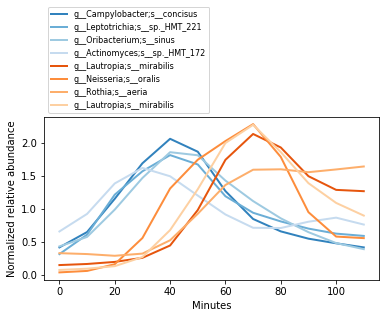

In [35]:
fig, ax = plt.subplots(figsize=(6, 3))
colors = plt.get_cmap('tab20c').colors
colors = colors[:len(asvs_tongue)] + colors[4:4+len(asvs_plaque)]

for o, color in zip(asvs_tongue + asvs_plaque,
                    colors):
    series = df_asv_median[o]  
    series_m = moving_average(series)
    series_m_scale = series_m / series_m.mean()
    taxa = ';'.join(saliva_ma.feature_metadata.loc[o, 'taxonomy'].split(';')[-2:])
    
    ax.plot(series_m_scale, label=taxa, linewidth=2, color=color)
    ax.legend(bbox_to_anchor=(0, 1.7), loc='upper left', fontsize=8)

ax.set_xlabel('Minutes')
ax.set_ylabel('Normalized relative abundance')